# Boostrap Consensus Trees - Lexico-Grammatical Style

In [1]:
import numpy as np
import pandas as pd

from typing import Callable, Collection, Union

from sklearn.preprocessing import Normalizer
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import FunctionTransformer
from sklearn.neighbors import KNeighborsClassifier

from ruzicka.test_metrics import nini

In [2]:
%load_ext rpy2.ipython

In [3]:
vecs = pd.read_csv("elegy_corpus.csv", index_col=0)

In [4]:
vecs

,Author,Work,Poem,LEN,Chunk
0,Ovid,Ep.,Ep. 1,116,hank tua penelope lento tibi mittit ulikse\nni...
1,Ovid,Ep.,Ep. 2,148,hospita demopoon tua te rodopeia pyllis\nultra...
2,Ovid,Ep.,Ep. 3,154,kwam legis a rapta briseide littera wenit\nwik...
3,Ovid,Ep.,Ep. 4,176,kwam nisi tu dederis karitura_st ipsa salutem\...
4,Ovid,Ep.,Ep. 5,158,perlegis an konjunks prohibet nowa perlege non...
...,...,...,...,...,...
301,ps-Ovid,Consolatio,Consolatio 3,158,kwo raperis laniata komas similiskwe furenti\n...
302,ps-Ovid,Ibis,Ibis 1,64,tempus ad hok lustris bis jam mihi kwinkwe per...
303,ps-Ovid,Ibis,Ibis 2,200,di maris et terrae kwi_kwis meliora tenetis\ni...
304,ps-Ovid,Ibis,Ibis 3,200,kwi_kwokulis karuit per kwos male widerat auru...


In [5]:
corpus = vecs[vecs.LEN >= 20]

## Tree #1: 2-, 3-, 4-grams, LSA

This method has worked well for me in general on a variety of Latin verse. It uses character n-grams drawn from the phonetically transformed texts. This puts us in a very high-dimension (20-30k features). The columns are then _z_-scaled (TF-IDF also works) and finally the dimension is reduced to 50 using Singular Value Decomposition. That general technique (SVD on frequency data) is called Latent Semantic Analysis in the literature, although there are many variations. Some more information can be found [here](https://scikit-learn.org/stable/modules/decomposition.html#lsa) although it is geared towards Python users.

In [6]:
from sklearn.decomposition import TruncatedSVD

vectorizer = make_pipeline(
    TfidfVectorizer(
        sublinear_tf=True,
        use_idf=False,
        norm="l2",
        analyzer="char",
        ngram_range=(2, 4),
    ),
    FunctionTransformer(lambda x: np.asarray(x.todense()), accept_sparse=True),
    TruncatedSVD(50, random_state=42),
    Normalizer(),
)

In [7]:
X = pd.DataFrame(vectorizer.fit_transform(corpus.Chunk))
y = list(corpus.Poem)

## Eder BCT

Boostrap Consensus Tree, as introduced [here](https://computationalstylistics.github.io/projects/bootstrap-networks/) and (more-or-less as) implemented in the _Stylo_ R package. Essentially it's a bootstrap loop where, at each iteration we do a subsample of features (columns) and calculate the 3 nearest neighbours for each point with a given metric. Edges are given 3 points for the nearest neighbour, then 2 for second and 1 for third, and finally all the scores are aggregated to produce a weighted graph. This version allows any feature universe and any metric as a callable. By default we return only the top 20% of the edges (this is an n x n-1 graph, after all).

In [8]:
def eder_bct(
    X: pd.DataFrame,
    y: list[str],
    n: int = 500,
    keep_pct: float = 0.2,
    feats_pct: float = 0.3,
    rng: np.random.Generator = np.random.default_rng(),
    metric: Union[
        Callable[[Collection[float], Collection[float]], float], str
    ] = "cosine",
) -> pd.DataFrame:
    dfs = []
    cl = KNeighborsClassifier(n_neighbors=3, metric=metric)
    for _ in range(n):
        # Sample feats_pct random features (columns)
        this_X = X.sample(int(X.shape[1] * feats_pct), axis=1, random_state=rng)

        # Calculate kNN in that space
        cl.fit(this_X, y)
        _, indices = cl.kneighbors(n_neighbors=3)

        # And build a dataframe from the results
        dicts = []
        for i, node_ary in enumerate(indices):
            for j, node in enumerate(node_ary):
                dicts.append(
                    {
                        "from": y[i],
                        "to": y[node],
                        # neighbors are sorted low distance to high
                        # so this gives us the 'inverse rank' ie lowest
                        # distance of n neighbors scores n, next is n-1 etc
                        # this is consistent with the stylo BCT algorithm
                        "weight": (len(node_ary) - j),
                    }
                )
        dfs.append(pd.DataFrame(dicts))

    # Now aggregate the dataframes, summing the weights for
    # identical (directed) edges
    graph = pd.concat(dfs).groupby(["from", "to"], as_index=False).agg(sum)
    graph_trim = graph.nlargest(int(len(graph) * keep_pct), "weight")
    return graph_trim

In [9]:
graph_trim = eder_bct(X, y, n=500, rng=np.random.default_rng(seed=42), metric="cosine")

In [10]:
%%R

# lengthy ggplot details pulled out to another file

source('do_bct.R')

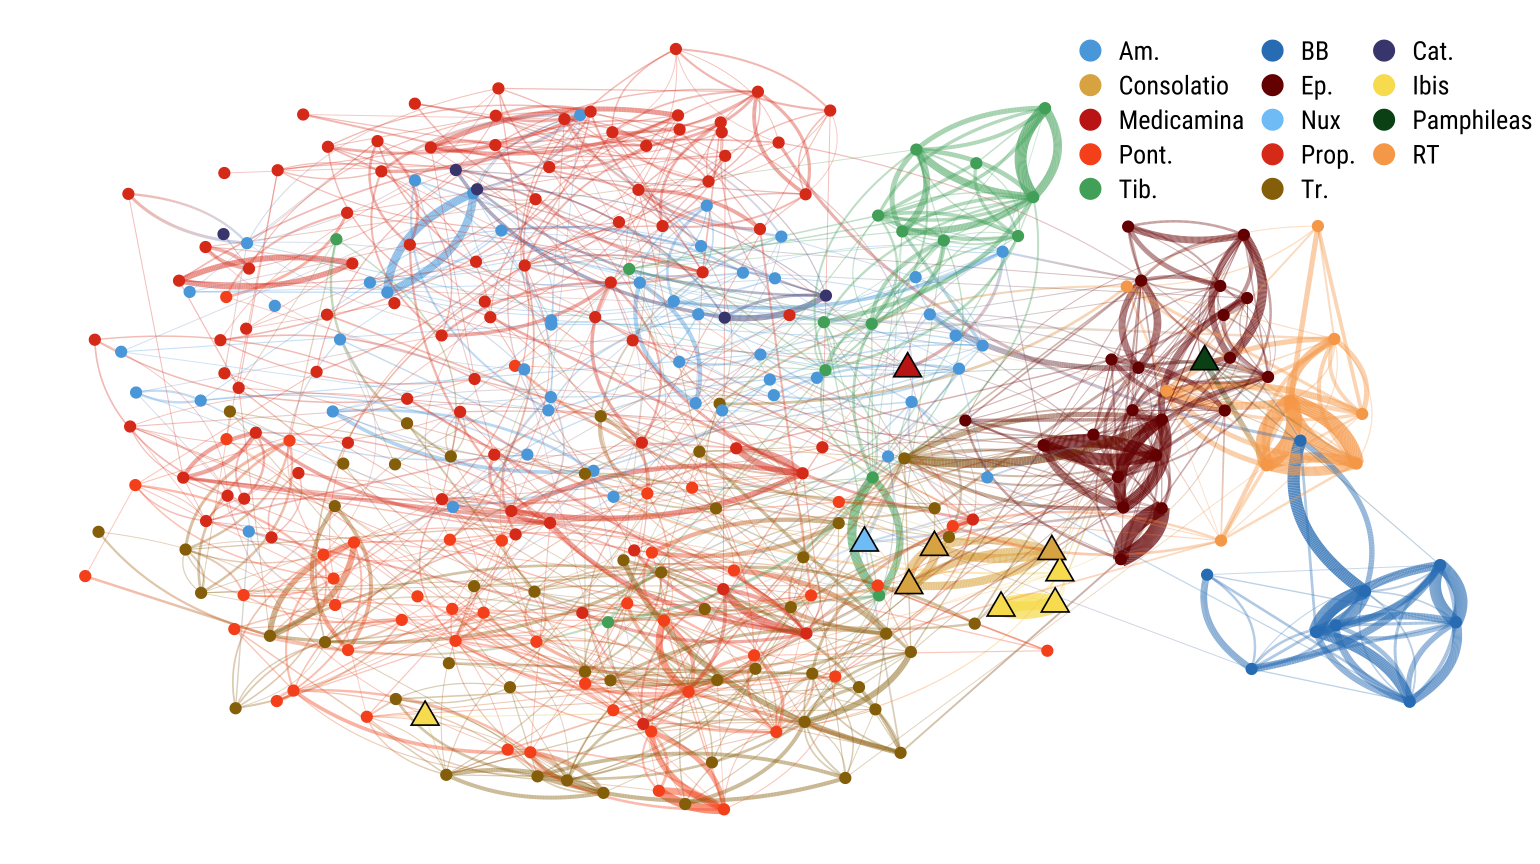

In [16]:
%%R -i graph_trim  -h 6 -w 10.7 -u in -r 144

p <- do_bct(
    graph_trim,
    'black',
    'white',
    lim=100, # minimum edge weight to draw. Does NOT affect point position.
    highlight=c("Nux", "Ibis", "Consolatio", "Medicamina", "Pamphileas"),
    legend_pos = c(0.85,0.87),
    flip=FALSE
)
# fn <- "bct_ngram.pdf"
# ggsave(plot=p, fn, dpi=600, width=10.7, height=6, device=cairo_pdf)
p

## Tree #2: 5-grams with 'Nini' metric

Based on the best performing metric in _Nini, A. (2023). A Theory of Linguistic Individuality for Authorship Analysis (Elements in Forensic Linguistics). Cambridge: Cambridge University Press. doi:10.1017/9781108974851_. For English the author uses huge n-grams (up to 9 grams) but for Latin 5 grams seem sufficient. The metric is essentially Pearson correlation on an indicator vector (0 for not-included 1 for included) and unlike the LSA method it is applied directly to the feature space (5000 most frequent 5-grams). Using two methods provides a useful comparison.

In [12]:
nini_vec = make_pipeline(
    TfidfVectorizer(
        sublinear_tf=True,
        use_idf=False,
        norm="l1",
        analyzer="char",
        ngram_range=(5, 5),
        max_features=5000,
    ),
    FunctionTransformer(lambda x: np.array(x.todense()), accept_sparse=True),
)
X_nini = pd.DataFrame(nini_vec.fit_transform(corpus.Chunk))

In [13]:
graph_nini_small = eder_bct(
    X_nini, y, n=500, rng=np.random.default_rng(seed=42), metric=nini
)

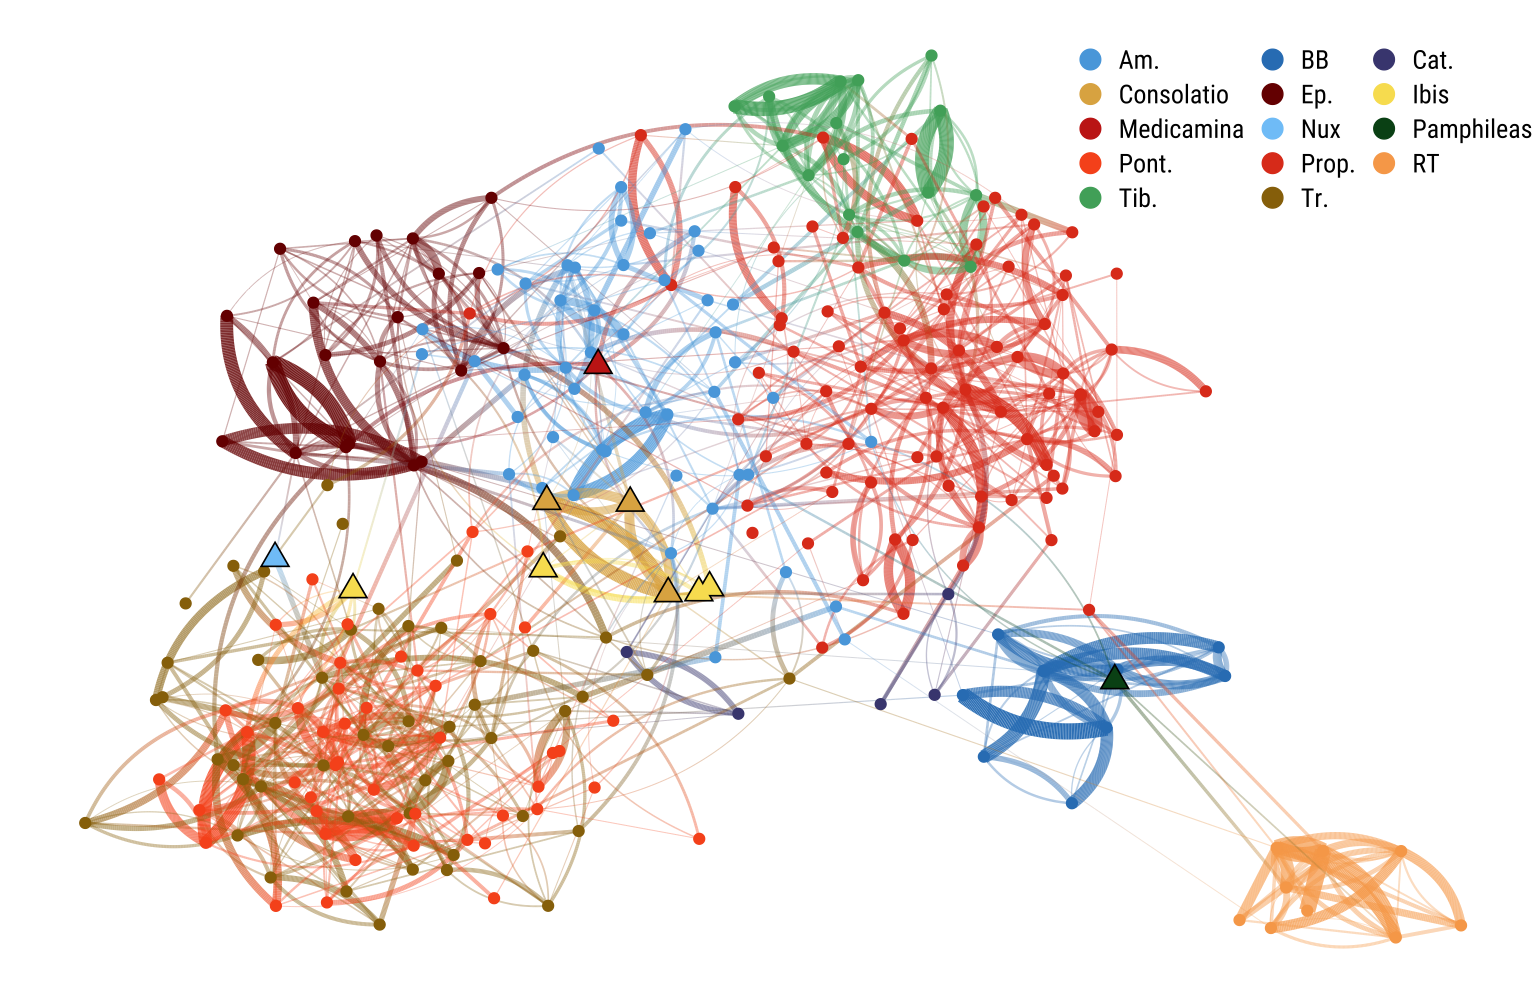

In [18]:
%%R -i graph_nini_small  -h 7 -w 10.7 -u in -r 144

p <- do_bct(
    graph_nini_small,
    'black',
    'white',
    lim=190,
    highlight=c("Nux", "Ibis", "Consolatio", "Medicamina", "Pamphileas"),
    legend_pos = c(0.85,0.88),
    flip=F
)
# fn <- "figures/bct_ngram_med.pdf"
# ggsave(plot=p, fn, dpi=600, width=10.7, height=7, device=cairo_pdf)
p